In [1]:
from decouple import config
import os
import pandas as pd
from nilearn import datasets, plotting, image
from sklearn import linear_model
from fNeuro.utils.pickling import load_pickle 
from fNeuro.connectivity.connectivity import get_correlation_long_df, get_mean_correlation_matrix, connectome_plotting
from fNeuro.connectivity.organise_networks import order_networks, seggregate_networks
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
from sklearn.feature_selection import r_regression


Read in time series and group together in order

In [2]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
group = np.asarray(list(time_series['an'].values()) + list(time_series['hc'].values()))

Read in connectome and get participant order

In [3]:
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
participant_order = load_pickle(os.path.join(resting_path, 'measures', 'connectome_participant_order'))
order = [re.findall('B\d\d\d\d', participant)[0] for participant in participant_order]
connectome_dict = dict(zip(order, connectome))

Read in autistic traits and pre-process

In [4]:
autistic_traits = pd.read_csv(os.path.join(resting_path, 'autistic_traits_neuroimaging.csv'))
autistic_traits['B_Number'] = autistic_traits['B_Number'].str.rstrip()
autistic_traits = autistic_traits.drop(autistic_traits[autistic_traits['B_Number'].str.contains('B2010')].index).reset_index(drop=True)
autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'

/tmp/ipykernel_3211337/3176687810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'


Read in msdl atlas and make into dataframe

In [5]:
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })

Read in all the models

In [6]:
full_models_ados ={
    'svr': load_pickle(os.path.join(resting_path, 'measures', 'svr_ados_unfitered')),
    'lasso': load_pickle(os.path.join(resting_path, 'measures', 'lasso_ados_unfitered')),
    'ridge': load_pickle(os.path.join(resting_path, 'measures', 'ridge_ados_unfitered')),
    'random_forest': load_pickle(os.path.join(resting_path, 'measures', 'ran_ados_unfitered')),
}

feature_selected_ados ={
    'svr': load_pickle(os.path.join(resting_path, 'measures', 'svr_ados_fitered')),
    'lasso': load_pickle(os.path.join(resting_path, 'measures', 'lasso_ados_fitered')),
    'ridge': load_pickle(os.path.join(resting_path, 'measures', 'ridge_ados_fitered')),
    'random_forest': load_pickle(os.path.join(resting_path, 'measures', 'ran_ados_fitered')),
}

full_models_aq10 ={
    'svr': load_pickle(os.path.join(resting_path, 'measures', 'svr_aq10_unfiltered')),
    'lasso': load_pickle(os.path.join(resting_path, 'measures', 'lasso_aq10_unfiltered')),
    'ridge': load_pickle(os.path.join(resting_path, 'measures', 'ridge_aq10_unfiltered')),
    'random_forest': load_pickle(os.path.join(resting_path, 'measures', 'random_forest_aq10_unfiltered')),
}

feature_selected_aq10 ={
    'svr': load_pickle(os.path.join(resting_path, 'measures', 'svr_aq10_filtered')),
    'lasso': load_pickle(os.path.join(resting_path, 'measures', 'lasso_aq10_filtered')),
    'ridge': load_pickle(os.path.join(resting_path, 'measures', 'ridge_aq10_filtered')),
    'random_forest': load_pickle(os.path.join(resting_path, 'measures', 'random_forest_aq10_filtered')),
}

Get mean correlation matrix and reorder into long form

In [7]:
correlation_matrix = get_mean_correlation_matrix(group, msdl['labels'])
an_df = get_correlation_long_df(correlation_matrix['an_mean_correlations'], msdl_overview_df).rename(columns={'corr_names': 'correlation_names'})

## AQ10

Order r2 and MAE by model type for aq and plot

In [8]:
aq10_full_model_scores = {'r2': pd.DataFrame(data={
                                            'lasso': full_models_aq10['lasso']['r2'],
                                            'ridge': full_models_aq10['ridge']['r2'],
                                            'random_forest': full_models_aq10['random_forest']['r2'],
                                            'svr': full_models_aq10['svr']['r2'],
                                                }),
                'MAE': pd.DataFrame(data={
                                            'lasso': full_models_aq10['lasso']['MAE'],
                                            'ridge': full_models_aq10['ridge']['MAE'],
                                            'random_forest': full_models_aq10['random_forest']['MAE'],
                                            'svr': full_models_aq10['svr']['MAE'],
                                                }),
}

aq10_feature_selected_scores = {'r2': pd.DataFrame(data={
                                            'lasso': feature_selected_aq10['lasso']['r2'],
                                            'ridge': feature_selected_aq10['ridge']['r2'],
                                            'random_forest': feature_selected_aq10['random_forest']['r2'],
                                            'svr': feature_selected_aq10['svr']['r2'],
                                                }),
                                'MAE': pd.DataFrame(data={
                                            'lasso': feature_selected_aq10['lasso']['MAE'],
                                            'ridge': feature_selected_aq10['ridge']['MAE'],
                                            'random_forest': feature_selected_aq10['random_forest']['MAE'],
                                            'svr': feature_selected_aq10['svr']['MAE'],
                                                }),
}

[Text(0.5, 1.0, 'MAE of feature selected models aq10')]

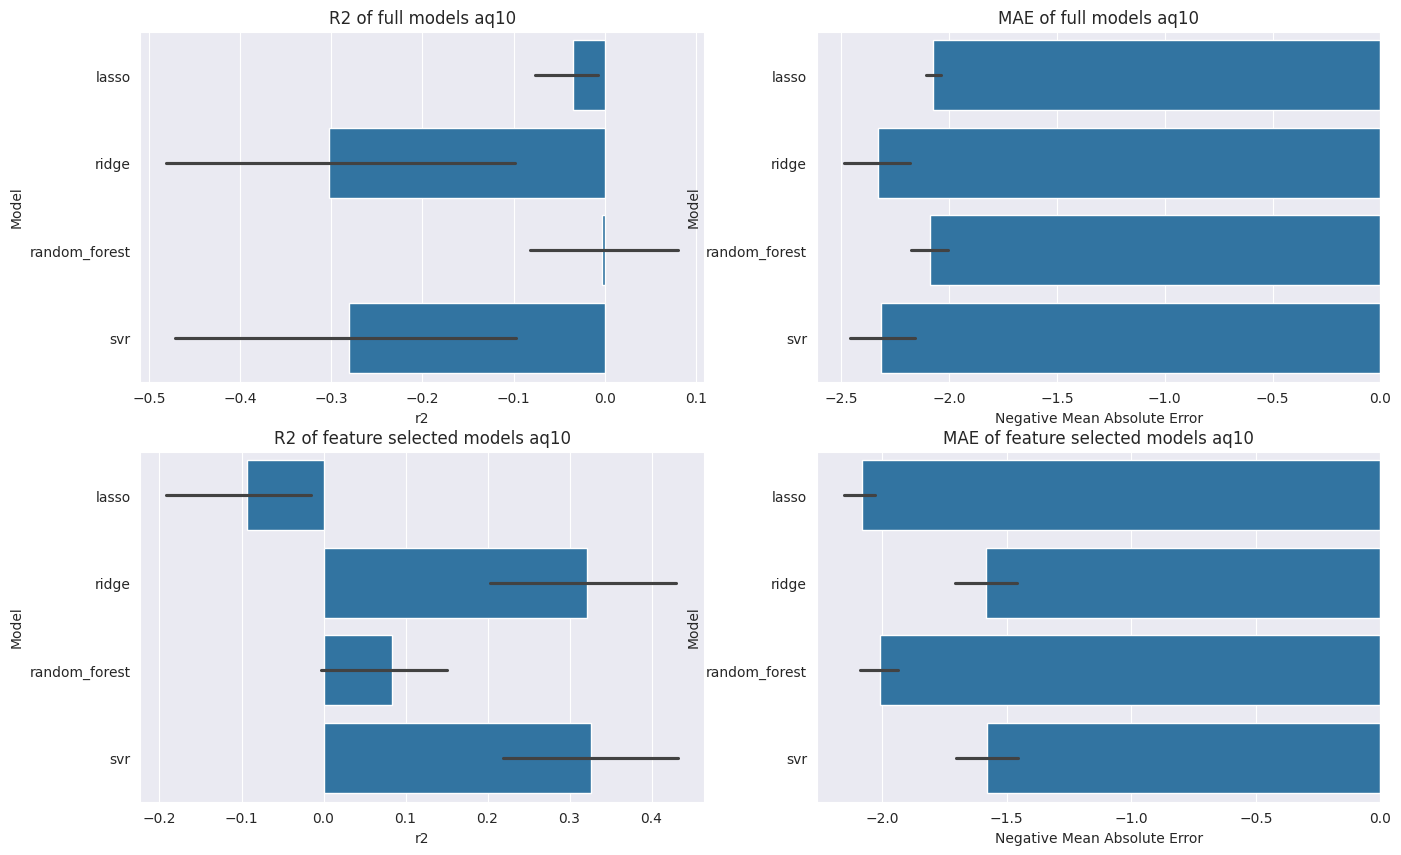

In [9]:
fig,ax = plt.subplots(2,2, figsize=(16,10))
sns.barplot(data=pd.melt(aq10_full_model_scores['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model', ax=ax[0][0]).set(title='R2 of full models aq10')
sns.barplot(data=pd.melt(aq10_full_model_scores['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model', ax=ax[0][1]).set(title='MAE of full models aq10')
sns.barplot(data=pd.melt(aq10_feature_selected_scores['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model', ax=ax[1][0]).set(title='R2 of feature selected models aq10')
sns.barplot(data=pd.melt(aq10_feature_selected_scores['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model', ax=ax[1][1]).set(title='MAE of feature selected models aq10')

filter out the X to leave only the correlations that had a small + correlation to the aq10. 

In [10]:
aq_df = autistic_traits[['B_Number', 'aq10']].dropna().reset_index(drop=True)
y_aq = aq_df['aq10'].values
x_aq = np.array([connectome_dict.get(key) for key in aq_df['B_Number'].values])
test = r_regression(x_aq, y_aq)
index = np.where((test > 0.1) | (test < -0.1))[0]
x = x_aq[0:, index]
an_df_aq = an_df.iloc[index]

In [11]:
an_df_aq['svr_values'] = feature_selected_aq10['svr']['model'].best_estimator_.coef_.T

/tmp/ipykernel_3211337/881171081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an_df_aq['svr_values'] = feature_selected_aq10['svr']['model'].best_estimator_.coef_.T


In [12]:
network_vals = order_networks(msdl_overview_df, an_df_aq, 'network_names')
network_seg = seggregate_networks(network_vals)

In [13]:
networks = network_seg['within_df'].groupby('network_names')
aq10_within = pd.DataFrame({'name': networks.svr_values.mean().idxmax(), 'value': networks.svr_values.mean().max()}, index=[0])
aq10_within

,name,value
0,Ant IPS - Ant IPS,0.007503


In [14]:
network_seg['within_df'][network_seg['within_df']['network_names'].str.contains(aq10_within['name'][0])]

,correlation_names,correlation,network_names,svr_values
1,R Ant IPS - L Ant IPS,0.813363,Ant IPS - Ant IPS,0.007503


In [15]:
pd.DataFrame(network_seg['between_df'].iloc[0]).T

,correlation_names,correlation,network_names,svr_values
0,L IPS - R Aud,-3.616464,D Att - Aud,0.009644


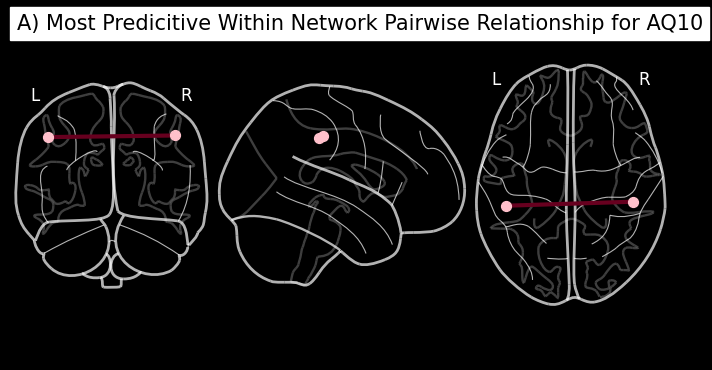

In [16]:
plot_parameters = connectome_plotting(network_seg['within_df'][network_seg['within_df']['network_names'].str.contains(aq10_within['name'][0])], 
                                      'svr_values', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='A) Most Predicitive Within Network Pairwise Relationship for AQ10')

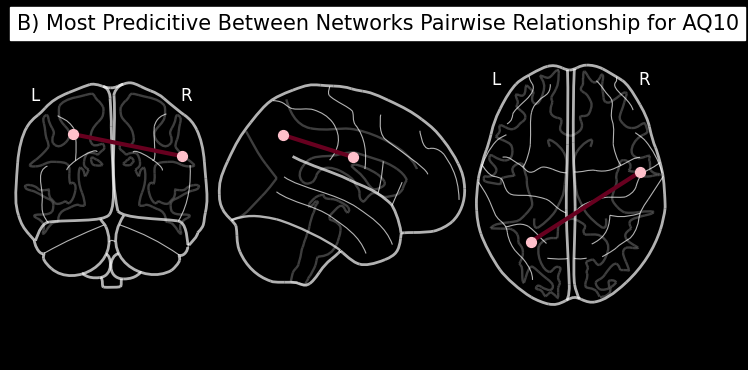

In [17]:
plot_parameters = connectome_plotting(pd.DataFrame(network_seg['between_df'].iloc[0]).T, 
                                      'svr_values', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='B) Most Predicitive Between Networks Pairwise Relationship for AQ10')

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


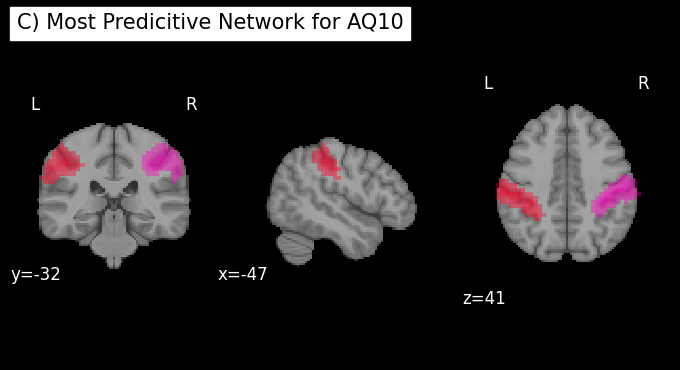

In [18]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(aq10_within['name'][0].split('-')[0].rstrip())].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(aq10_within['name'][0].split('-')[0].rstrip())]['region_coords'].to_list()[0],
    cmap='gist_rainbow',
    title='C) Most Predicitive Network for AQ10'
)

## ADOS


In [19]:
ados_full_model_scores = {'r2': pd.DataFrame(data={
                                            'lasso': full_models_ados['lasso']['r2'],
                                            'ridge': full_models_ados['ridge']['r2'],
                                            'random_forest': full_models_ados['random_forest']['r2'],
                                            'svr': full_models_ados['svr']['r2'],
                                                }, index=[0]),
                'MAE': pd.DataFrame(data={
                                            'lasso': full_models_ados['lasso']['MAE'],
                                            'ridge': full_models_ados['ridge']['MAE'],
                                            'random_forest': full_models_ados['random_forest']['MAE'],
                                            'svr': full_models_ados['svr']['MAE'],
                                                }, index=[0]),
}

ados_feature_selected_scores = {'r2': pd.DataFrame(data={
                                            'lasso': feature_selected_ados['lasso']['r2'],
                                            'ridge': feature_selected_ados['ridge']['r2'],
                                            'random_forest': feature_selected_ados['random_forest']['r2'],
                                            'svr': feature_selected_ados['svr']['r2'],
                                                }, index=[0]),
                                'MAE': pd.DataFrame(data={
                                            'lasso': feature_selected_ados['lasso']['MAE'],
                                            'ridge': feature_selected_ados['ridge']['MAE'],
                                            'random_forest': feature_selected_ados['random_forest']['MAE'],
                                            'svr': feature_selected_ados['svr']['MAE'],
                                                }, index=[0]),
}

[Text(0.5, 1.0, 'MAE of feature selected models ADOS')]

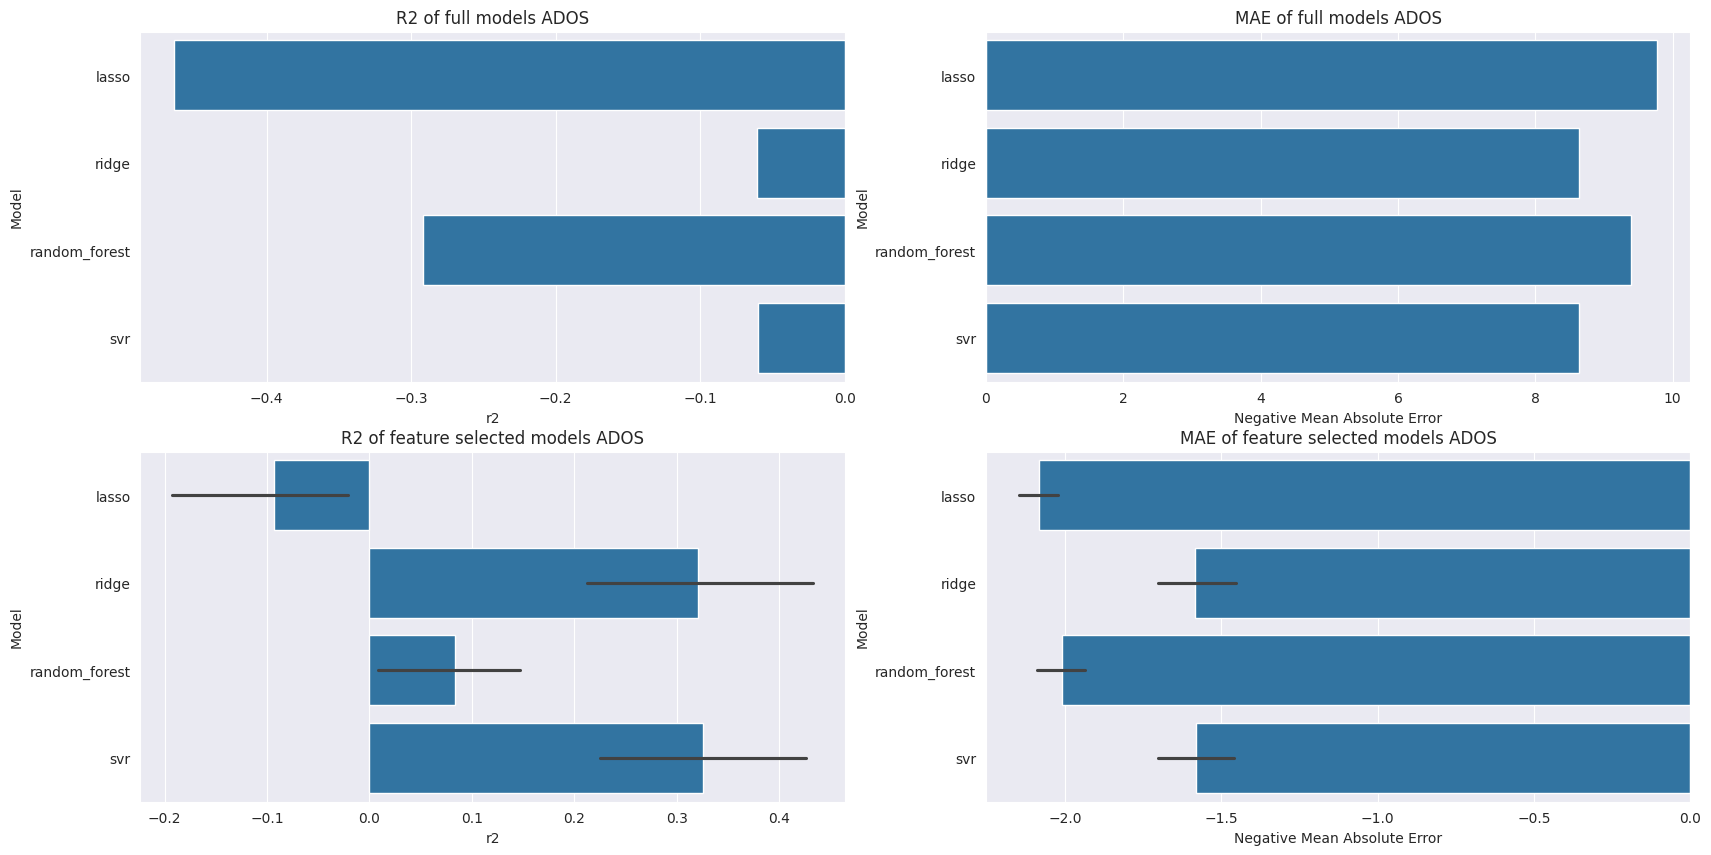

In [20]:
fig,ax = plt.subplots(2,2, figsize=(20,10))
sns.barplot(data=pd.melt(ados_full_model_scores['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model', ax=ax[0][0]).set(title='R2 of full models ADOS')
sns.barplot(data=pd.melt(ados_full_model_scores['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model', ax=ax[0][1]).set(title='MAE of full models ADOS')
sns.barplot(data=pd.melt(aq10_feature_selected_scores['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model', ax=ax[1][0]).set(title='R2 of feature selected models ADOS')
sns.barplot(data=pd.melt(aq10_feature_selected_scores['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model', ax=ax[1][1]).set(title='MAE of feature selected models ADOS')

In [21]:
ados_df = autistic_traits[['B_Number', 'ADOS total']].dropna().reset_index(drop=True)
y_ados = ados_df['ADOS total'].values
x_ados = np.array([connectome_dict.get(key) for key in ados_df['B_Number'].values])
test = r_regression(x_ados, y_ados)
index = np.where((test > 0.1) | (test < -0.1))[0]
x_ados = x_ados[0:, index]
an_df_ados = an_df.iloc[index]

In [22]:
an_df_ados['svr_values'] = feature_selected_ados['svr']['model'].best_estimator_.coef_.T

/tmp/ipykernel_3211337/60189309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an_df_ados['svr_values'] = feature_selected_ados['svr']['model'].best_estimator_.coef_.T


In [23]:
network_vals_ados = order_networks(msdl_overview_df, an_df_ados, 'network_names')
network_seg_ados = seggregate_networks(network_vals_ados)

In [24]:
networks = network_seg_ados['within_df'].groupby('network_names')
ados_within = pd.DataFrame({'name': networks.svr_values.mean().idxmax(), 'value': networks.svr_values.mean().max()}, index=[0])
ados_within

,name,value
0,Salience - Salience,0.01365


In [25]:
network_seg_ados['within_df'][network_seg_ados['within_df']['network_names'].str.contains(ados_within['name'][0])]

,correlation_names,correlation,network_names,svr_values
0,V ACC - D ACC,2.064568,Salience - Salience,0.01365


In [26]:
network_seg_ados['between_df'].iloc[0]

correlation_names    Dors PCC - L Front pol
correlation                        3.854216
network_names            Dors PCC - L V Att
svr_values                        -0.021394
Name: 0, dtype: object

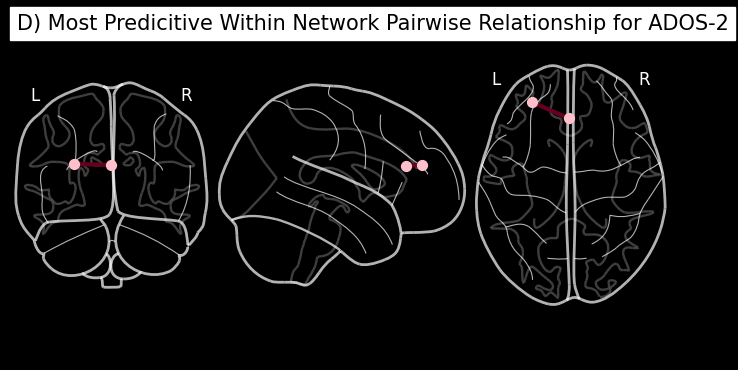

In [27]:
plot_parameters = connectome_plotting(network_seg_ados['within_df'][network_seg_ados['within_df']['network_names'].str.contains(ados_within['name'][0])], 
                                      'svr_values', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='D) Most Predicitive Within Network Pairwise Relationship for ADOS-2')

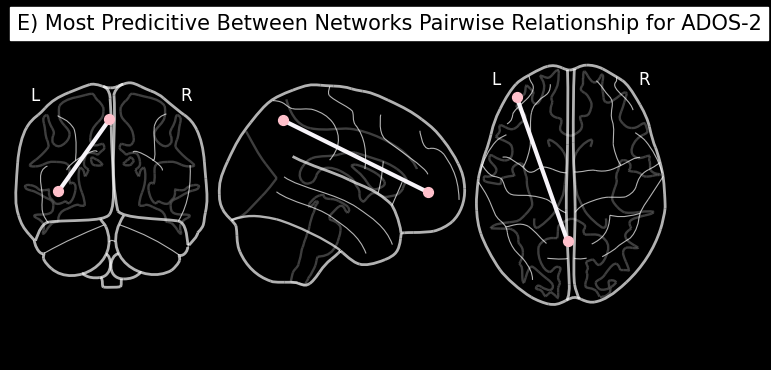

In [28]:
plot_parameters = connectome_plotting(pd.DataFrame(network_seg_ados['between_df'].iloc[0]).T, 
                                      'svr_values', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='E) Most Predicitive Between Networks Pairwise Relationship for ADOS-2')

In [32]:
msdl_overview_df[msdl_overview_df['networks'].str.contains(ados_within['name'][0].split('-')[0].rstrip())].index.to_list()

[22, 23, 24]

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


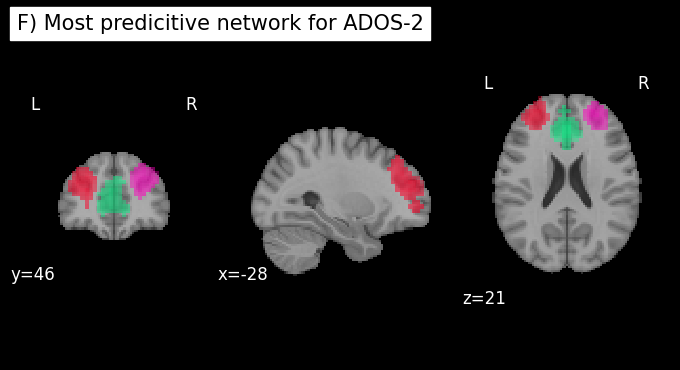

In [29]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(ados_within['name'][0].split('-')[0].rstrip())].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(ados_within['name'][0].split('-')[0].rstrip())]['region_coords'].to_list()[0],
    cmap='gist_rainbow',
    title='F) Most predicitive network for ADOS-2'
)